In [2]:
#@title 1.1. Classes e funções

import sys
sys.path.append('/home/ABTLUS/victor.secco/data_processing') 
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import os
from scipy.signal import butter, filtfilt
from mypackages.eRDF import butter_lowpass_filter,DataProcessor, read_discus_fit_file
from mypackages.eRDF import optimize_constant, rw

from PIL import Image
import hyperspy.api as hs
import cv2
from mypackages.edp_processing import ImageAnalysis, ImageProcessing, peak_calibration
from mypackages.plot_style import set_plot_style

set_plot_style()

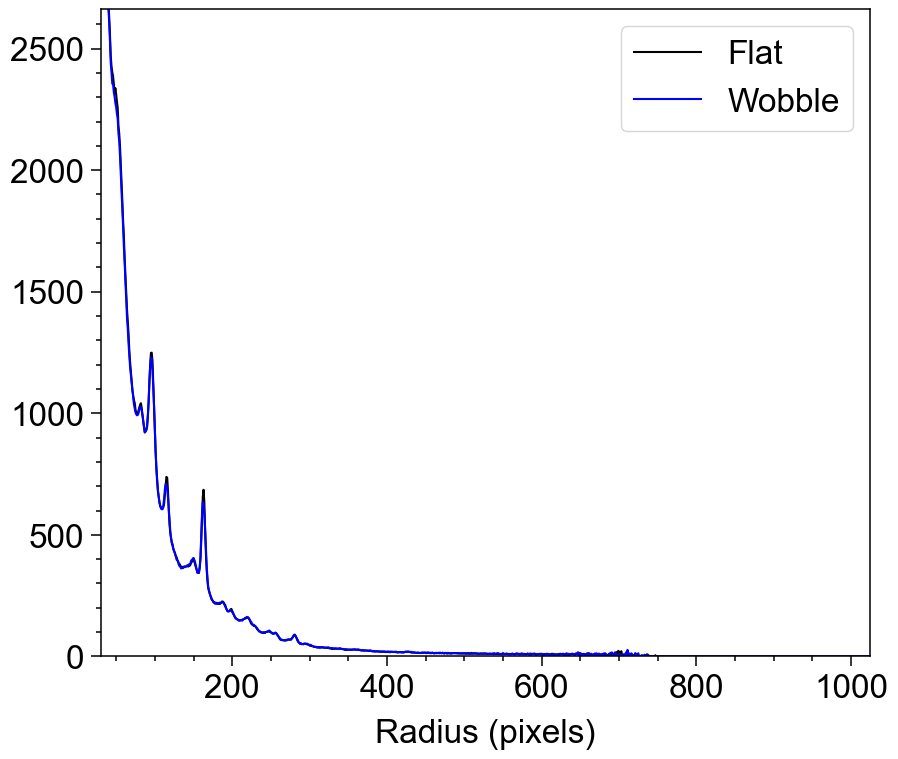

In [8]:
save_path = r"C:\Users\seccolev\data_processing\data\processed\ePDF\Fe3O4"

flat = pd.read_csv(os.path.join(save_path,("F-Fe3O4-E-A-s6.csv")), sep = "\t", header = None)
wob = pd.read_csv(os.path.join(save_path,("F-Fe3O4-E-A-s6_wob.csv")), sep = "\t", header = None)

wob_iq = wob[0].values
flat_iq = flat[0].values

plt.plot(flat_iq, label = "Flat")
plt.plot(wob_iq, label = "Wobble")
plt.xlabel("Radius (pixels)")
plt.xlim(30, 1024)
plt.ylim(0, 0.05 * np.max(flat[0]))
plt.legend()

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy.polynomial.chebyshev import chebval

# --- Normalize x for Chebyshev ---
def normalize_to_unit(x):
    return 2 * (x - x.min()) / (x.max() - x.min()) - 1

# --- Chebyshev background model ---
def chebyshev_background(x, *cheb_coeffs):
    x_scaled = normalize_to_unit(x)
    return chebval(x_scaled, cheb_coeffs)

# --- Baseline mask using local quantile ---
def baseline_mask_quantile(y, window_size=301, quantile=0.1):
    y = np.asarray(y)
    mask = np.zeros_like(y, dtype=bool)
    half_window = window_size // 2

    for i in range(len(y)):
        left = max(0, i - half_window)
        right = min(len(y), i + half_window)
        local_slice = y[left:right]
        threshold = np.quantile(local_slice, quantile)
        if y[i] <= threshold:
            mask[i] = True

    return mask

# --- Full background fitting function ---
def fit_background_with_chebyshev(x, y, order=4, window_size=200, quantile=0.05):
    if x is None:
        x = np.arange(len(y))

    mask = baseline_mask_quantile(y, window_size=window_size, quantile=quantile)
    x_baseline = x[mask]
    y_baseline = y[mask]

    initial_guess = [0] * (order + 1)
    popt, _ = curve_fit(chebyshev_background, x_baseline, y_baseline, p0=initial_guess)
    background = chebyshev_background(x, *popt)
    signal = y - background

    return background, signal, mask

# --- Example usage ---

end = 400
start = 40

x = np.arange(start-1, end-1)
y_obs = wob_iq[start:end]

background, signal, mask = fit_background_with_chebyshev(x, y_obs, order=8, window_size=200, quantile=0.1)


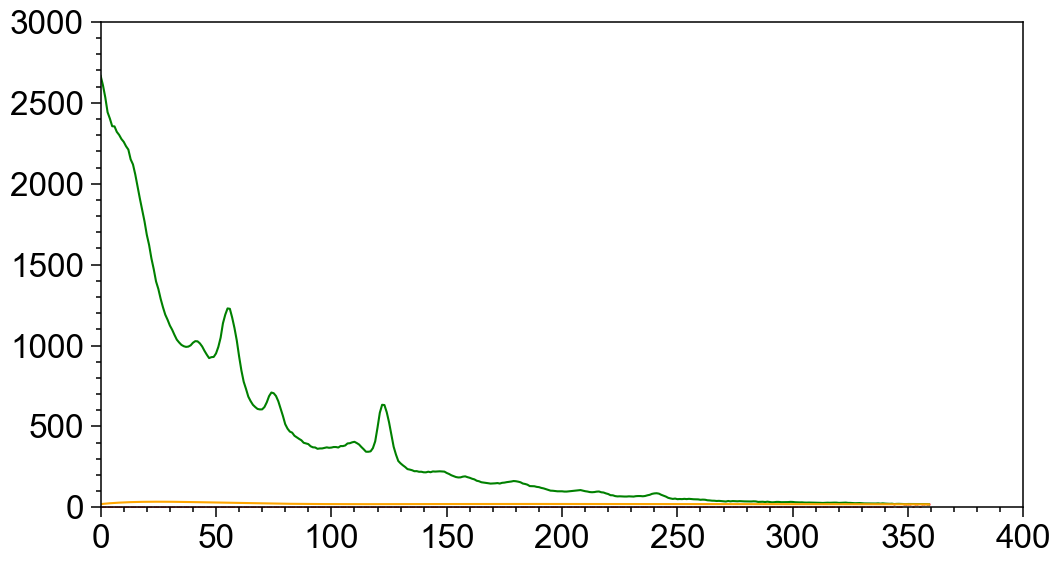

In [32]:
x = np.arange(len(y_obs))  # Adjust x to match the length of y_obs
plt.figure(figsize=(12, 6))
plt.plot(x, y_obs, label='Background-subtracted Signal', color='green')
plt.plot(x, background, label='Fitted Background', color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.scatter(x, mask*y_obs, color='red', s=1, label='Baseline Mask', alpha=0.5)


C:\Users\seccolev\AppData\Local\Temp\ipykernel_34012\2744462919.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x, signal**(1/2), label='Background-subtracted Signal', color='green')


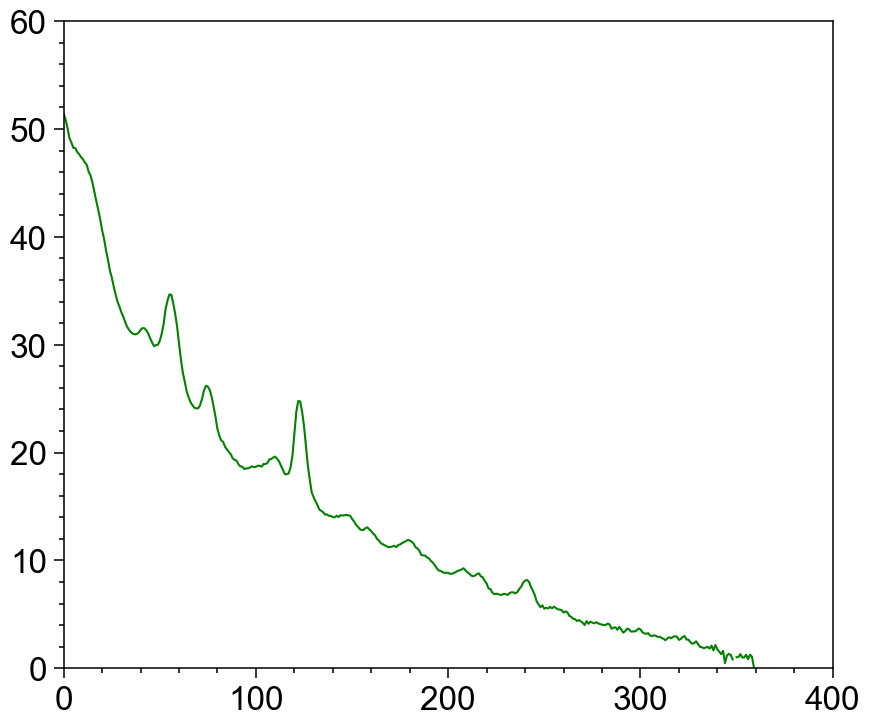

In [33]:
plt.plot(x, signal**(1/2), label='Background-subtracted Signal', color='green')